In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import json
import io
import subprocess

### Load data

In [ ]:
# Get file from the branch general-exploration
RailLine = subprocess.run(
    ["git", "show", "main:data/cleaned/RailLines.geojson"],
    capture_output=True,
    text=True,
    check=True
)

rail_line = gpd.read_file(io.StringIO(RailLine.stdout))
# rail_line = rail_line.to_crs(3857)
# rail_line = gpd.read_file('dsa4264-lta-geospatial/data/cleaned/RailLines.geojson')
print(rail_line.head())
rail_line.crs

In [ ]:
# Get file from the branch general-exploration
RailStation = subprocess.run(
    ["git", "show", "main:data/cleaned/RailStationsMerged.geojson"],
    capture_output=True,
    text=True,
    check=True
)

rail_stn = gpd.read_file(io.StringIO(RailStation.stdout))
# .to_crs(3857)
# rail_stn = gpd.read_file('dsa4264-lta-geospatial/data/cleaned/RailStationsMerged.geojson')
print(rail_stn.head())



#### Bus LineStrings

In [61]:
# Get file from the branch general-exploration
BusRoutes = subprocess.run(
    ["git", "show", "main:data/cleaned/BusRoutes.json"],
    capture_output=True,
    text=True,
    check=True
)

data = pd.read_json(io.StringIO(BusRoutes.stdout), encoding="utf-8", lines=True, chunksize=1000)
# data = pd.read_json("dsa4264-lta-geospatial/data/cleaned/BusRoutes.json", encoding="utf-8", lines=True, chunksize=1000)

# Combine chunks into a dataframe
df_list = []
for chunk in data:
    df_list.append(chunk)

# Concatenate all chunks into a single dataframe
bus_routes = pd.concat(df_list, ignore_index=True)
bus_routes = bus_routes[bus_routes['Direction']==1]
bus_routes = bus_routes[['ServiceNo', 'BusStopCode', 'StopSequence', 'Distance']]
print(bus_routes.head())

  ServiceNo  BusStopCode  StopSequence  Distance
0        10        75009             1       0.0
1        10        76059             2       0.6
2        10        76069             3       1.1
3        10        96289             4       2.3
4        10        96109             5       2.7


In [65]:
# Get file from the branch general-exploration
BusStops = subprocess.run(
    ["git", "show", "main:data/cleaned/BusStops.geojson"],
    capture_output=True,
    text=True,
    check=True
)

bus_stops = gpd.read_file(io.StringIO(BusStops.stdout)).to_crs(32648)

# Load BusStops.geojson using GeoPandas
# bus_stops = gpd.read_file('dsa4264-lta-geospatial/data/cleaned/BusStops.geojson')

print(bus_stops.head())
bus_stops.crs

   BUS_STOP_N BUS_ROOF_N         LOC_DESC                       geometry
0       65059        B12     ST ANNE'S CH   POINT (377770.78 154000.188)
1       16171        B06  YUSOF ISHAK HSE  POINT (363642.782 143603.062)
2       61101        NIL          BLK 120  POINT (373583.973 147657.504)
3        1239        B01     SULTAN PLAZA   POINT (373353.81 144032.943)
4       17269        B01          BLK 730  POINT (362337.597 144267.297)


<Projected CRS: EPSG:32648>
Name: WGS 84 / UTM zone 48N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 102°E and 108°E, northern hemisphere between equator and 84°N, onshore and offshore. Cambodia. China. Indonesia. Laos. Malaysia - West Malaysia. Mongolia. Russian Federation. Singapore. Thailand. Vietnam.
- bounds: (102.0, 0.0, 108.0, 84.0)
Coordinate Operation:
- name: UTM zone 48N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [66]:
## Merge Bus Stop Coordinates with Bus Routes
# Ensure that BusStopCode is of the same type for both DataFrames (string)
bus_stops['BusStopCode'] = bus_stops['BUS_STOP_N'].astype(str)
bus_routes['BusStopCode'] = bus_routes['BusStopCode'].astype(str)

# Merge bus_routes with bus_stops to get geometry for each bus stop
merged_bus_data = bus_routes.merge(bus_stops[['BusStopCode', 'geometry']], on='BusStopCode', how='left')

# Drop rows without geometry
merged_bus_data = merged_bus_data.dropna(subset=['geometry'])

# Convert to GeoDataFrame
bus_routes_geo = gpd.GeoDataFrame(merged_bus_data, geometry='geometry')
# bus_routes_geo.to_crs(3857)
bus_routes_geo.set_crs(epsg=32648, inplace=True)
bus_routes_geo.head()

,ServiceNo,BusStopCode,StopSequence,Distance,geometry
0,10,75009,1,0.0,POINT (382479.99 149772.212)
1,10,76059,2,0.6,POINT (382257.146 149576.907)
2,10,76069,3,1.1,POINT (382307.904 149087.517)
3,10,96289,4,2.3,POINT (383004.155 148143.843)
4,10,96109,5,2.7,POINT (383262.649 147839.518)


### Segment Bus Routes by LineString

  ServiceNo                                           geometry
0        10  LINESTRING (382479.99 149772.212, 382257.146 1...
1       100  LINESTRING (374479.342 149295.696, 374511.914 ...
2      100A  LINESTRING (374479.342 149295.696, 374511.914 ...
3       101  LINESTRING (374479.342 149295.696, 374602.888 ...
4       102  LINESTRING (376740.13 151559.417, 377110.624 1...


/var/folders/hx/j3t1dc5d6539d5c6zm67rnf00000gn/T/ipykernel_58024/2572441167.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bus_routes_geo.groupby(['ServiceNo'])


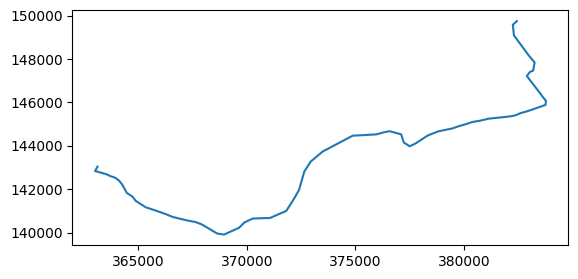

In [73]:
bus_routes_lines = (
    bus_routes_geo.groupby(['ServiceNo'])
    .apply(lambda x: LineString(x.sort_values('StopSequence')['geometry'].tolist()))
    .reset_index()
    .rename(columns={0: 'geometry'})
)
# Convert to GeoDataFrame
bus_routes_lines = gpd.GeoDataFrame(bus_routes_lines, geometry='geometry')
bus_routes_lines = bus_routes_lines.set_crs(epsg=32648)
print(bus_routes_lines.head())

bs10 = bus_routes_lines[bus_routes_lines['ServiceNo']=='10']

bs10.plot()
plt.show()

##### Plot segments against original bus route to check

[<LINESTRING (382479.99 149772.212, 382433.572 148917.191)>, <LINESTRING (382433.572 148917.191, 383029.365 148114.162)>, <LINESTRING (383029.365 148114.162, 382985.657 147324.761)>, <LINESTRING (382985.657 147324.761, 383429.033 146530.459)>, <LINESTRING (383429.033 146530.459, 383545.178 145805.014)>, <LINESTRING (383545.178 145805.014, 382594.422 145496.484)>, <LINESTRING (382594.422 145496.484, 381621.979 145298.007)>, <LINESTRING (381621.979 145298.007, 380636.986 145135.189)>, <LINESTRING (380636.986 145135.189, 379675.138 144869.186)>, <LINESTRING (379675.138 144869.186, 378709.364 144619.358)>, <LINESTRING (378709.364 144619.358, 377835.07 144144.303)>, <LINESTRING (377835.07 144144.303, 377137.661 144439.482)>, <LINESTRING (377137.661 144439.482, 376227.297 144595.115)>, <LINESTRING (376227.297 144595.115, 375238.054 144481.901)>, <LINESTRING (375238.054 144481.901, 374312.143 144165.987)>, <LINESTRING (374312.143 144165.987, 373436.091 143686.869)>, <LINESTRING (373436.091 14

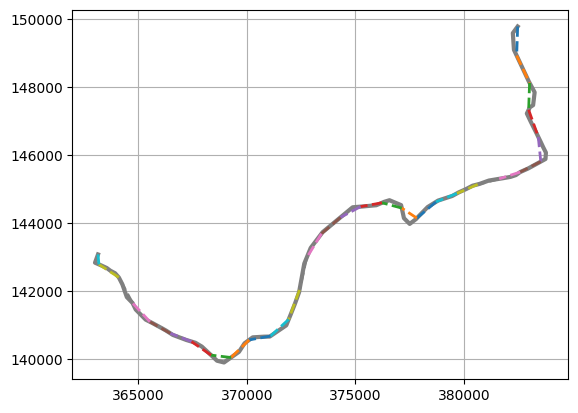

In [83]:
def segment_line_by_distance(line, distance=1000):
    segments = []  # List to store the line segments
    current_distance = 0  # Start distance

    # Iterate over the entire length of the line and create segments of the specified distance
    while current_distance < line.length:
        # Calculate the start and end points for each segment
        start_point = line.interpolate(current_distance)
        end_point = line.interpolate(min(current_distance + distance, line.length))
        
        # Create a LineString for the segment and add it to the list
        segments.append(LineString([start_point, end_point]))
        
        # Move to the next segment
        current_distance += distance

    return segments  # Return the list of 1 km line segments

# Segment the line by 1 km distance
bs10_segmented = segment_line_by_distance(bs10.geometry.iloc[0], 1000)
print(bs10_segmented)
# plot orignal bus line
x, y = bs10.geometry.iloc[0].xy  # Extract x and y coordinates for the original line
plt.plot(x, y, color='gray', linewidth=3, label='Original Bus Line')

# plot segmented bus line
for segment in bs10_segmented:
    x_seg, y_seg = segment.xy  # Extract x and y coordinates for the segment
    plt.plot(x_seg, y_seg, linewidth=2, linestyle='--')

# Show the plot
plt.grid(True)
plt.show()

### Train LineStrings

In [36]:
rail_stn = rail_stn.to_crs(epsg=32648)

#  Group the stations by MRT line
rail_stn.drop(rail_stn[rail_stn['StationCode']=='PTC'].index, inplace=True)
rail_stn.drop(rail_stn[rail_stn['StationCode']=='STC'].index, inplace=True)
rail_stn.replace("TE22A", "TE22.5", inplace=True)
station_groups = rail_stn.groupby('StationLine')

# Dictionary to store LineStrings for each MRT line
line_strings_per_station_line = {}

# Iterate over each MRT line group and create a sorted LineString
for line_name, group in station_groups:
    # Sort the stations by their longitude (x-coordinate) or latitude (y-coordinate)
    group['centroid_x'] = group.geometry.centroid.x  # Get x-coordinate of the centroid
    group['StationCodeNo'] = group['StationCode'].str[2:].astype(float)
    sorted_group = group.sort_values('StationCodeNo')  # Sort by the x-coordinate

    # Extract the station centroids, names, and codes
    station_points = sorted_group.geometry.centroid.tolist()
    station_names = sorted_group['StationName'].tolist()
    station_codes = sorted_group['StationCode'].tolist()

    # Initialize a set to track unique station codes
    unique_station_codes = set()

    # Initialize lists to store filtered stations (with unique codes)
    filtered_station_points = []
    filtered_station_names = []
    filtered_station_codes = []

    #Filter out stations with duplicate station codes and None values
    for point, name, code in zip(station_points, station_names, station_codes):
        if code not in unique_station_codes and point is not None:
            # Add the station to the filtered lists
            filtered_station_points.append(point)
            filtered_station_names.append(name)
            filtered_station_codes.append(code)

            # Mark this station code as seen
            unique_station_codes.add(code)

    # create a LineString from the filtered station points
    if filtered_station_points:  # Check if we have valid points
        try:
            mrt_line = LineString(filtered_station_points)
        
            # Store the data in the dictionary
            line_strings_per_station_line[line_name] = {
                'LineString': mrt_line,
                'StationNames': filtered_station_names,
                'StationCodes': filtered_station_codes,
                'StationPoints': filtered_station_points
            }
        except TypeError as e:
            print(f"Error creating LineString for {line_name}: {e}")
            continue

print(line_strings_per_station_line)
for line_name, line_data in line_strings_per_station_line.items():
    print(f"MRT Line: {line_name}")
    print(f"  LineString: {line_data['LineString']}")
    print(f"  Station Names: {line_data['StationNames']}")
    print(f"  Station Codes: {line_data['StationCodes']}")
    print(f"  Station Points (centroids): {line_data['StationPoints']}")
    print("\n")

{'Bukit Panjang LRT': {'LineString': <LINESTRING (360309.027 153140.435, 360411.414 152601.551, 360829.656 152414...>, 'StationNames': ['Choa Chu Kang', 'South View', 'Keat Hong', 'Teck Whye', 'Phoenix', 'Bukit Panjang', 'Petir', 'Pending', 'Bangkit', 'Fajar', 'Segar', 'Senja'], 'StationCodes': ['BP1', 'BP2', 'BP3', 'BP4', 'BP5', 'BP6', 'BP7', 'BP8', 'BP9', 'BP10', 'BP11', 'BP13'], 'StationPoints': [<POINT (360309.027 153140.435)>, <POINT (360411.414 152601.551)>, <POINT (360829.656 152414.918)>, <POINT (361346.739 152198.743)>, <POINT (361829.093 152415.808)>, <POINT (362235.186 152463.085)>, <POINT (362789.705 152319.091)>, <POINT (363302.833 152138.828)>, <POINT (363456.769 152568.697)>, <POINT (363254.156 153068.205)>, <POINT (363123.233 153424.677)>, <POINT (362311.693 152865.997)>]}, 'Circle': {'LineString': <LINESTRING (371555.63 143685.879, 373066.751 141713.911, 372568.151 141121....>, 'StationNames': ['Dhoby Ghaut', 'Bayfront', 'Marina Bay', 'Bras Basah', 'Esplanade', 'Promen

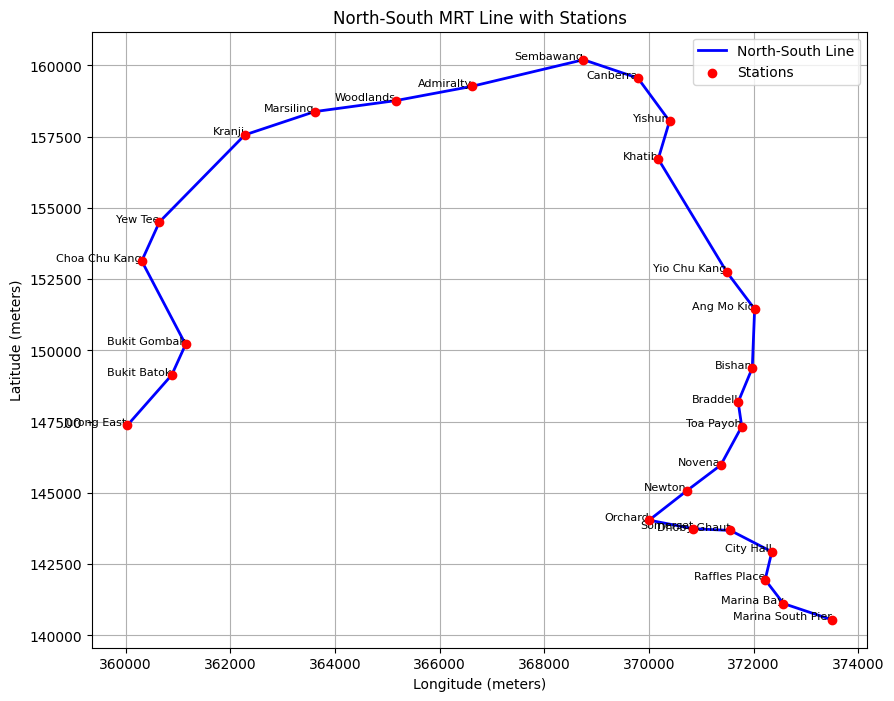

In [37]:
target_line = "North-South" #change accordingly

# Check if the line exists in the processed data
if target_line in line_strings_per_station_line:
    line_data = line_strings_per_station_line[target_line]

    # Extract the LineString, station points, and station names
    mrt_line = line_data['LineString']
    station_points = line_data['StationPoints']
    station_names = line_data['StationNames']

    # Plot the MRT line
    plt.figure(figsize=(10, 8))
    
    # Plot the LineString representing the MRT line
    x, y = mrt_line.xy  # Extract x and y coordinates from the LineString
    plt.plot(x, y, label=f'{target_line} Line', color='blue', linewidth=2)
    
    # Plot the station points on the map
    station_x = [point.x for point in station_points]
    station_y = [point.y for point in station_points]
    plt.scatter(station_x, station_y, color='red', label='Stations', zorder=5)

    # Annotate the station names
    for i, name in enumerate(station_names):
        plt.text(station_x[i], station_y[i], name, fontsize=8, ha='right')

    # Set the title and labels
    plt.title(f'{target_line} MRT Line with Stations')
    plt.xlabel('Longitude (meters)')
    plt.ylabel('Latitude (meters)')
    
    # Add a legend
    plt.legend()
    
    # Show the plot
    plt.grid(True)
    plt.show()

else:
    print(f"No data available for MRT Line: {target_line}")

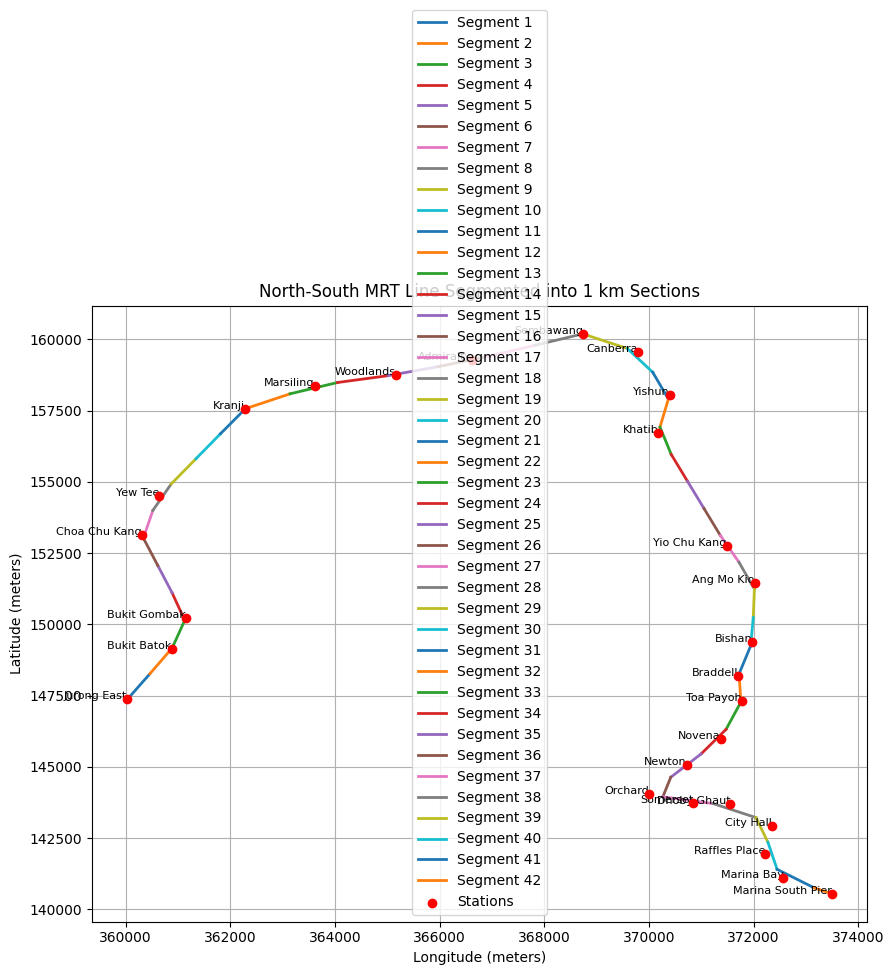

Segment 1: LINESTRING (360032.37446507503 147368.7958131729, 360464.9001491333 148270.41742595175)
Segment 2: LINESTRING (360464.9001491333 148270.41742595175, 360890.72366262943 149174.44560571364)
Segment 3: LINESTRING (360890.72366262943 149174.44560571364, 361130.54015205376 150145.26384379953)
Segment 4: LINESTRING (361130.54015205376 150145.26384379953, 360890.14415681665 151107.38106271153)
Segment 5: LINESTRING (360890.14415681665 151107.38106271153, 360615.31591612304 152068.8744002429)


In [38]:
# Function to segment a LineString into 1 km sections
def segment_line_by_distance(line, distance=1000):
    segments = []  # List to store the line segments
    current_distance = 0  # Start distance

    # Iterate over the entire length of the line and create segments of the specified distance
    while current_distance < line.length:
        # Calculate the start and end points for each segment
        start_point = line.interpolate(current_distance)
        end_point = line.interpolate(min(current_distance + distance, line.length))
        
        # Create a LineString for the segment and add it to the list
        segments.append(LineString([start_point, end_point]))
        
        # Move to the next segment
        current_distance += distance

    return segments  # Return the list of 1 km line segments

# Dictionary to store segmented lines for each MRT line
segmented_lines_per_station_line = {}

# Iterate through each MRT line in the dataset
for line_name, line_info in line_strings_per_station_line.items():
    # Get the LineString and station details for each line
    mrt_line = line_info['LineString']
    station_points = line_info['StationPoints']
    station_names = line_info['StationNames']

    # Segment the MRT line into 1 km sections
    mrt_segments = segment_line_by_distance(mrt_line, 1000)

    # Store the segments for this MRT line
    segmented_lines_per_station_line[line_name] = {
        'segments': mrt_segments,
        'station_names': station_names,
        'station_points': station_points
    }

target_line = "North-South"  # change to visualize other lines
if target_line in segmented_lines_per_station_line:
    segmented_data = segmented_lines_per_station_line[target_line]

    mrt_segments = segmented_data['segments']
    station_points = segmented_data['station_points']
    station_names = segmented_data['station_names']

    # Visualize the segments on the map
    plt.figure(figsize=(10, 8))

    # Plot each segment in a different color
    for idx, segment in enumerate(mrt_segments):
        x_seg, y_seg = segment.xy  # Extract x and y coordinates for the segment
        plt.plot(x_seg, y_seg, label=f'Segment {idx+1}', linewidth=2)

    # Plot the station points
    station_x = [point.x for point in station_points]
    station_y = [point.y for point in station_points]
    plt.scatter(station_x, station_y, color='red', label='Stations', zorder=5)

    # Annotate the station names
    for i, name in enumerate(station_names):
        plt.text(station_x[i], station_y[i], name, fontsize=8, ha='right')

    # Set the title and labels
    plt.title(f'{target_line} MRT Line Segmented into 1 km Sections')
    plt.xlabel('Longitude (meters)')
    plt.ylabel('Latitude (meters)')

    # Add a legend
    plt.legend()
    
    # Show the plot
    plt.grid(True)
    plt.show()

    # Print the first few segments for verification
    for idx, segment in enumerate(mrt_segments[:5]):  # Print first 5 segments
        print(f"Segment {idx+1}: {segment}")

else:
    print(f"No data available for MRT Line: {target_line}")

### Compare each segment of the bus route to its nearest mrt line.

In [80]:
if bus_routes_lines.crs is None:
    bus_routes_lines = bus_routes_lines.set_crs(epsg=4326)

#Reproject bus routes to the same CRS as the MRT lines (UTM Zone 48N - EPSG:32648)
bus_routes_lines = bus_routes_lines.to_crs(epsg=32648)

mrt_buffers = {}  # Dictionary to store buffers for each MRT line
buffer_distance = 300
for line_name, line_data in line_strings_per_station_line.items():
    mrt_line = line_data['LineString']
    mrt_buffer = mrt_line.buffer(buffer_distance)  # Create a buffer around the MRT line
    mrt_buffers[line_name] = mrt_buffer  # Store the buffer

#Check if any bus route is near any MRT line buffer
overlap_results = []

for line_name, mrt_buffer in mrt_buffers.items():
    for idx, bus_route in bus_routes_lines.iterrows():
        if bus_route.geometry.intersects(mrt_buffer):
            overlap_length = bus_route.geometry.intersection(mrt_buffer).length  # Get overlap length
            overlap_results.append({
                'MRT_Line': line_name,
                'Bus_ServiceNo': bus_route['ServiceNo'],
                # 'Direction': bus_route['Direction'],  # Keep track of direction for later
                'Bus_Route_Length_m': bus_route.geometry.length,  # Length of the bus route in meters
                'Overlap_Length_m': overlap_length  # Overlap length in meters
            })

overlap_df = pd.DataFrame(overlap_results)

#Sort the DataFrame by 'Overlap_Length_m' in descending order
overlap_df_sorted = overlap_df.sort_values(by='Overlap_Length_m', ascending=False)

# For each bus service, keep only the direction with the greater overlap
# Group by 'Bus_ServiceNo' and 'Direction', take the max 'Overlap_Length_m' for each service
overlap_df_max = overlap_df_sorted.groupby(['Bus_ServiceNo']).apply(lambda x: x.loc[x['Overlap_Length_m'].idxmax()]).reset_index(drop=True)

# Drop duplicates for each 'Bus_ServiceNo' while keeping only the row with the maximum 'Overlap_Length_m'
overlap_df_unique = overlap_df_max.sort_values(by='Overlap_Length_m', ascending=False).drop_duplicates(subset=['Bus_ServiceNo'], keep='first')

# Output the final DataFrame
overlap_df_unique

/var/folders/hx/j3t1dc5d6539d5c6zm67rnf00000gn/T/ipykernel_58024/783497063.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  overlap_df_max = overlap_df_sorted.groupby(['Bus_ServiceNo']).apply(lambda x: x.loc[x['Overlap_Length_m'].idxmax()]).reset_index(drop=True)


,MRT_Line,Bus_ServiceNo,Bus_Route_Length_m,Overlap_Length_m
339,East-West,63,33442.621667,19492.797271
267,Thomson East Coast,36,44616.364459,19236.935180
187,East-West,24,45129.781783,18769.556820
181,Downtown,23,27525.880005,17548.327027
359,Downtown,67,30761.463662,17539.811053
...,...,...,...,...
392,North-South,803,2506.308145,245.299063
395,North-South,806,4633.388118,245.299063
131,East-West,17A,3112.491295,244.821882
505,North-South,962C,1250.818701,137.683073


### Comparison using MRT Segments
- The code chunk below is the original code from anthea's method, excluding the consideration for bus direction. 
- We are counting the number of MRT Segments that overlap with the bus route as a percentage of the total number of segments in the whole MRT Line.

In [99]:
# Initialize a list to store the results
segment_coverage_results = []

# Iterate through each row in overlap_df_unique
for idx, row in overlap_df_unique.iterrows():
    # Fetch the geometry of the bus route (LineString) based on ServiceNo and Direction
    bus_geometry = bus_routes_lines.loc[
        (bus_routes_lines['ServiceNo'] == row['Bus_ServiceNo']) 
    ].geometry.iloc[0]
    
    # Fetch the MRT Line geometry
    mrt_line = line_strings_per_station_line[row['MRT_Line']]['LineString']
    
    # Segment the MRT line 
    mrt_segments = segment_line_by_distance(mrt_line, 1000)  # EDIT

    # Calculate how many segments are covered by the bus route
    total_segments = len(mrt_segments)
    covered_segments = 0

    for segment in mrt_segments:
        if bus_geometry.intersects(segment):  # Check if the bus route intersects the MRT segment
            covered_segments += 1

    # Calculate the percentage of MRT segments covered by the bus route
    coverage_percentage = (covered_segments / total_segments) * 100 if total_segments > 0 else 0
    
    # Append the result to the list
    segment_coverage_results.append({
        'MRT_Line': row['MRT_Line'],
        'Bus_ServiceNo': row['Bus_ServiceNo'],
        'Bus_Route_Length_m': row['Bus_Route_Length_m'],
        'Overlap_Length_m': row['Overlap_Length_m'],
        'Coverage_Percentage': coverage_percentage
    })

# Convert the results to a DataFrame
segment_coverage_df = pd.DataFrame(segment_coverage_results)

# Filter the DataFrame to only include rows with a Coverage_Percentage > 0
segment_coverage_df_filtered = segment_coverage_df[segment_coverage_df['Coverage_Percentage'] > 0]

# Sort by coverage percentage in descending order
segment_coverage_df_sorted = segment_coverage_df_filtered.sort_values(by='Coverage_Percentage', ascending=False)

# Output the final DataFrame
segment_coverage_df_sorted.head()

,MRT_Line,Bus_ServiceNo,Bus_Route_Length_m,Overlap_Length_m,Coverage_Percentage
139,Bukit Panjang LRT,976,7464.432230,6257.797219,50.0
47,Sengkang LRT,102,22426.851650,8740.751137,50.0
188,Punggol LRT,84G,5175.941134,5175.941134,50.0
274,Bukit Panjang LRT,975,33732.482499,3971.177379,50.0
425,Bukit Panjang LRT,975C,16980.660182,2075.837235,50.0


### Comparison using Bus Segments 
- The method below segments the bus routes and checks how many consecutive bus segments overlap with the MRT LineString. It also tracks percentage of bus segments that are intersecting with the MRT Linestring in a similar concept to the code above.
- This method is in consideration of routes that are not always intersecting with the MRT (like the example given in consult) and hence should not be counted as parallel.

In [104]:
# Initialize a list to store the results
segment_coverage_results = []

# Iterate through each row in the overlap DataFrame
for idx, row in overlap_df_unique.iterrows():
    # Fetch the geometry of the bus route based on ServiceNo
    bus_geometry = bus_routes_lines.loc[
        (bus_routes_lines['ServiceNo'] == row['Bus_ServiceNo'])
    ].geometry.iloc[0]
    
    # Fetch the MRT line geometry
    mrt_line = line_strings_per_station_line[row['MRT_Line']]['LineString']
    
    # Segment the bus route into 1 km sections
    bus_segments = segment_line_by_distance(bus_geometry, 1000)

    # Initialize variables to track intersections and consecutive streaks
    total_segments = len(bus_segments)
    max_consecutive = 0
    current_consecutive = 0
    total_intersecting_segments = 0

    # Iterate over the bus segments and check for intersections with the MRT line
    for segment in bus_segments:
        if mrt_line.intersects(segment):  # If the segment intersects
            current_consecutive += 1  # Increment the consecutive count
            total_intersecting_segments += 1  # Track the total intersections
        else:
            max_consecutive = max(max_consecutive, current_consecutive)  # Track the max streak
            current_consecutive = 0  # Reset the consecutive count

    # Ensure the last streak is recorded
    max_consecutive = max(max_consecutive, current_consecutive)

    # Calculate the percentage of total segments in the longest streak
    consecutive_coverage = (max_consecutive / total_segments) * 100 if total_segments > 0 else 0
    total_segment_perc = (total_intersecting_segments/total_segments)* 100 if total_segments > 0 else 0
    # Append the result to the list
    segment_coverage_results.append({
        'MRT_Line': row['MRT_Line'],
        'Bus_ServiceNo': row['Bus_ServiceNo'],
        'Bus_Route_Length_m': row['Bus_Route_Length_m'],
        'Overlap_Length_m': row['Overlap_Length_m'],
        'Intersecting_Segments_Percentage': total_segment_perc,
        'Consecutive_Coverage_Percentage': consecutive_coverage,
        'Max_Consecutive_Segments': max_consecutive
    })

# Convert the results into a DataFrame
segment_coverage_df = pd.DataFrame(segment_coverage_results)

# Filter to include only meaningful overlaps
segment_coverage_df_filtered = segment_coverage_df[segment_coverage_df['Intersecting_Segments_Percentage'] > 0]

# Sort by total intersecting segments and then consecutive coverage percentage
segment_coverage_df_sorted = segment_coverage_df_filtered.sort_values(
    by=['Intersecting_Segments_Percentage', 'Consecutive_Coverage_Percentage'], 
    ascending=[False, False]
)

# Output the final DataFrame
print(segment_coverage_df_sorted.head(5))


          MRT_Line Bus_ServiceNo  Bus_Route_Length_m  Overlap_Length_m  \
320   Sengkang LRT           371         3670.834138       3496.948538   
360  Jurong Region           98A         2960.207397       2907.602673   
395  Jurong Region          154A         2451.852352       2451.852352   
457    North-South          302A         1929.302493       1613.444169   
466  Jurong Region          240A         1424.858635       1424.858635   

     Intersecting_Segments_Percentage  Consecutive_Coverage_Percentage  \
320                             100.0                            100.0   
360                             100.0                            100.0   
395                             100.0                            100.0   
457                             100.0                            100.0   
466                             100.0                            100.0   

     Max_Consecutive_Segments  
320                         4  
360                         3  
395           

### Ignore this part

In [95]:
x = bus_routes_lines.loc[
        (bus_routes_lines['ServiceNo'] == '36')
    ].geometry.iloc[0]
bus_segments = segment_line_by_distance(x, 1000)
# mrt = line_strings_per_station_line['Thomson East Coast']['LineString'].buffer(300)

intersections = []
for segment in bus_segments:
    for idx,row in rail_line.iterrows():
        line = row['geometry'].buffer(300)
        if segment.intersects(line): 
            intersection = segment.intersection(line)  # Get intersection
            intersections.append(intersection)  # Store the intersection geometry

In [ ]:
# List to store intersection data
records = []

# Iterate through all bus routes
for bus_no, bus_data in segmented_bus_routes.items():
    segments = bus_data['segments']
    # busstopcodes = bus_data['BusStopCodes']
    # busstoppoints = bus_data['busstoppoints']

    # Check each segment against the rail lines
    for segment in segments:

        for idx, row in rail_line.iterrows():
            line = row['geometry'].buffer(300)

            # If there is an intersection, store the data
            if segment.intersects(line):
                intersection = segment.intersection(line)

                # Create a record for this intersection
                records.append({
                    'bus_no': bus_no,
                    # 'busstopcodes': busstopcodes,
                    # 'busstoppoints': busstoppoints,
                    'intersection': intersection
                })

# Create a GeoDataFrame from the intersection records
gdf_intersections = gpd.GeoDataFrame(
    records, 
    geometry='intersection', 
    crs=rail_line.crs
)

# Display the resulting GeoDataFrame
print(gdf_intersections.head())


ValueError: aspect must be finite and positive 

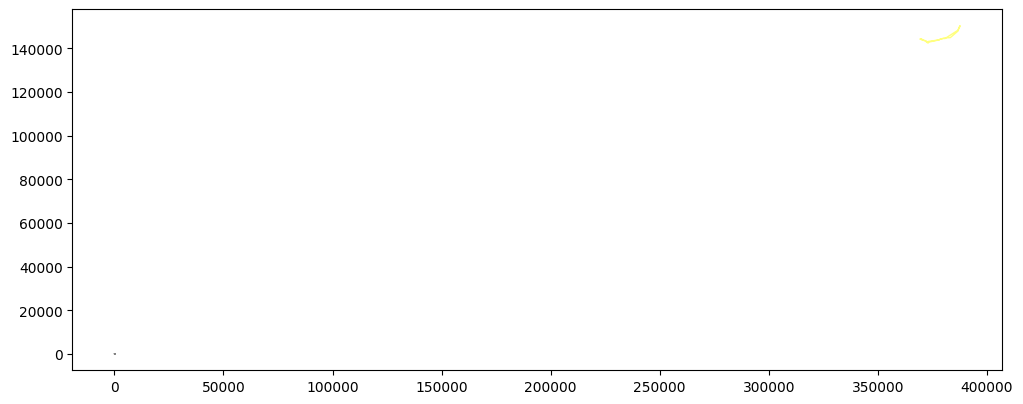

In [96]:
# Create a GeoDataFrame from the intersections
gdf_intersections = gpd.GeoDataFrame(geometry=intersections, crs=rail_line.crs)

# Plot the intersections on a map
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the rail lines
rail_line.plot(ax=ax, color='gray', linewidth=1, label='Rail Lines')

# Plot the bus segments
gpd.GeoSeries(x).plot(ax=ax, color='yellow', linewidth=1, alpha=0.5, label='Bus Segments')

# Plot the intersections
gdf_intersections.plot(ax=ax, color='red', markersize=50, label='Intersections')

# Add legend and title
ax.legend()
ax.set_title('Bus Route and Rail Line Intersections', fontsize=16)

# Clean up the plot
ax.set_axis_off()

# Show the plot
plt.show()

In [ ]:
# Create a spatial index for the rail line geometries
rail_line_sindex = rail_line.sindex

# List to store intersection data
records = []

# Iterate through all bus routes
for bus_no, bus_data in segmented_bus_routes.items():
    segments = bus_data['segments']

    # Check each segment against the rail lines using the spatial index
    for segment in segments:
        # Buffer the segment to ensure comparison is spatially accurate
        segment_buffered = segment.buffer(300)

        # Use spatial index to get possible rail line candidates
        possible_matches_index = list(rail_line_sindex.intersection(segment_buffered.bounds))
        possible_matches = rail_line.iloc[possible_matches_index]

        # Check actual intersections with possible matches
        for _, row in possible_matches.iterrows():
            line = row['geometry']

            if segment_buffered.intersects(line):
                intersection = segment_buffered.intersection(line)

                # Store the intersection record
                records.append({
                    'bus_no': bus_no,
                    'intersection': intersection
                })

# Create a GeoDataFrame from the intersection records
gdf_intersections = gpd.GeoDataFrame(
    records, 
    geometry='intersection', 
    crs=rail_line.crs
)

print(gdf_intersections.head())


#### Segment Bus Routes using the 'Distance' column

In [ ]:
segmented_bus_routes = {}

# Group by ServiceNo
for service_no, group in bus_routes_geo.groupby('ServiceNo'):
    group = group.sort_values('Distance')  # Ensure stops are in sequence
    points = group['geometry'].tolist()
    codes = group['BusStopCode'].tolist()
    distances = group['Distance'].tolist()

    # Store all bus stop codes and points for the route
    all_stops_data = {
        'BusStopCodes': codes,
        'BusStopPoints': points
    }

    # Initialize segments
    segments = []
    current_segment_points = [points[0]]  # Start with the first point
    current_distance = 0.0

    # Create segments based on the Distance column
    for i in range(1, len(points)):
        segment_distance = distances[i] - distances[i - 1]

        if current_distance + segment_distance <= 1.0:
            # Add the point to the current segment
            current_segment_points.append(points[i])
            current_distance += segment_distance
        else:
            # Create a LineString if the segment has more than one point
            if len(current_segment_points) > 1:
                segments.append(LineString(current_segment_points))

            # Reset for the new segment
            current_segment_points = [points[i]]
            current_distance = 0.0

    # Add the final segment if it has more than one point
    if len(current_segment_points) > 1:
        segments.append(LineString(current_segment_points))

    # Store the route data in the dictionary
    segmented_bus_routes[service_no] = {
        'segments': segments,
        **all_stops_data  # Include bus stop codes and points
    }

segmented_bus_routes

In [ ]:
target_line = "117"  # change to visualize other lines

segmented_data = segmented_bus_routes[target_line]

mrt_segments = segmented_data['segments']
station_points = segmented_data['BusStopPoints']
station_names = segmented_data['BusStopCodes']

# Visualize the segments on the map
plt.figure(figsize=(10, 8))

# Plot each segment in a different color
for idx, segment in enumerate(mrt_segments):
    x_seg, y_seg = segment.xy  # Extract x and y coordinates for the segment
    plt.plot(x_seg, y_seg, label=f'Segment {idx+1}', linewidth=2)

# Plot the station points
# station_x = [point.x for point in station_points]
# station_y = [point.y for point in station_points]
# plt.scatter(station_x, station_y, color='red', label='Bus Stops', zorder=5)

# # Annotate the station names
# for i, name in enumerate(station_names):
#     plt.text(station_x[i], station_y[i], name, fontsize=8, ha='right')

# Set the title and labels
plt.title(f'Bus Route {target_line} with 1km segments')
plt.xlabel('Longitude (meters)')
plt.ylabel('Latitude (meters)')

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

# Print the first few segments for verification
for idx, segment in enumerate(mrt_segments[:5]):  # Print first 5 segments
    print(f"Segment {idx+1}: {segment}")